<a href="https://www.kaggle.com/code/afi1289/nlp-with-disaster-tweets-cleaning-tf-idf-and-bert?scriptVersionId=117209515" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; If you find this notebook useful in anyway, please upvote it so that it can reach a bigger audience 🔥.
</div>

In [1]:
%%capture
# install textacy
!pip install textacy

In [2]:
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

# visualization using plotly
pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

%matplotlib inline
import numpy as np

# 0. Get the First Impression of your Dataset

In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
print(df_train.columns)

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in **train.csv** only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [4]:
df_train.sample(2, random_state=42).head(2)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-imaginable destruction.,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0


In [5]:
df_train.sample(1, random_state=123).T

,1971
id,2836
keyword,cyclone
location,NaN
text,1970 Mercury Cyclone GT Hood Moulding Very NICE CORE Cobra Jet 429CJ GT http://t.co/jOBVBvKFnZ http://t.co/C8zPmZhTDE
target,0


Let's find the distribution of the target variable:

In [6]:
df_train['target'].value_counts().sort_index().plot(kind='bar')

Only 3721 tweets are about a real disaster! Let's calculate some statistics for our tweets:

In [7]:
# add new column to calculate the length of each tweet
df_train['length'] = df_train['text'].str.len()

# compute the summary statistics for the columns
df_train[["length"]].describe().T

,count,mean,std,min,25%,50%,75%,max
length,7613.0,101.037436,33.781325,7.0,78.0,107.0,133.0,157.0


In [8]:
# show the boxplot for the length column
df_train["length"].plot(kind="box")

In [9]:
# show the histogram for the length column
df_train["length"].plot(kind="hist", bins=30)

Let's compare the distributions of the tweet lengths of both categories:

In [10]:
# create figure instance
fig = go.Figure()


fig.add_trace(go.Violin(
            y=df_train.query("target==1")["length"],
            name="Disaster",
            legendgroup = "F",
            jitter=0.5,
            scalegroup = "M",
            fillcolor='rgba(93, 164, 214, 0.5)',
            marker_size=5,
            line_width=1,
            box_visible=True,
            points= "all")
        )

fig.add_trace(go.Violin(
            y=df_train.query("target==0")["length"],
            name="Non-Disaster",
            legendgroup = "F",
            jitter=0.5,
            scalegroup = "M",
            fillcolor='rgba(255, 144, 14, 0.5)',
            marker_size=5,
            line_width=1,
            box_visible=True,
            points= "all")
        )
# we use update_layout() method to update multiple nested nested properties of a figure's layout
fig.update_layout(
    title='Violin and Box plots visualizing the distribution of tweet lenghts over categories',
    margin=dict( # set margins for left, right, bottom, and top
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)', # Sets the background color of the paper where the graph is drawn
    plot_bgcolor='rgb(243, 243, 243)',  # Sets the background color of the plotting area in-between x and y axes
    showlegend=False,
)

fig.show()

Non-Disaster tweets are more likely to have 68 characters or less.

By looking at the first values in the `location` column we remark that it has some missing values. Let's check them:

In [11]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

There are 3 methods for handling missing data:

1. Drop rows/columns containing NaN values using `df.dropna()`
2. Fill in missing data using `df.fillna()`
3. Flag rows contining missing data

We are going to substitute the missing values in the columns (`location`, `keyword` ) using other value such as unknown:

In [12]:
# fillna returns a new object, but you can modify the existing object inplace (so be careful :) )
df_train["keyword"].fillna("unknown", inplace=True)
df_train["location"].fillna("unknown", inplace=True)

In [13]:
df_train.query("keyword != 'unknown' \
                and location != 'unknown_'").sample(2, random_state=42)

,id,keyword,location,text,target,length
1184,1705,bridge%20collapse,"Playa del Carmen, Mexico",Two giant cranes holding a bridge collapse into nearby homes http://t.co/lSQe7nu6kl,1,83
424,614,arsonist,SF Bay Area,#Arsonist arrested for setting many fires. WATCH tonightÛªs other #headlines: http://t.co/sqgogJ3S5r. #Nightbeat @VeronicaDLCruz #2MinuteMix,1,141


# 1. Data Preparation

In [14]:
# select relevant columns
df_train = df_train[['keyword','location','text','target','length']]

In [15]:
# define noise removal function
import html

# define clean function
# add / remove any line if necessary
def clean(text):
    # convert html escapes like &amp; by their plain-text representation
    text = html.unescape(text) 
    
    # subsitute tags like <tab> by spaces in the specified text or remove them
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # subsitute markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # subsitute text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # subsitute standalone sequences of specials, matches &# but NOT #hashtag
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    
    # subsitute standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    #remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)  
    
    #remove old style retweet text "RT"
    text = re.sub(r'RT[\s]+', '', text)        
    text = re.sub(r'DT[\s]+', '', text)   
    
    #remove hashtags
    text = re.sub(r'#', '', text)
    
    return text.strip()

In [16]:
from textacy import preprocessing
from functools import partial

# create cleaning pipeline
preproc = preprocessing.make_pipeline(
    
    # join words split by a hyphen or line break
    preprocessing.normalize.hyphenated_words,
    
    # subsitute fancy quatation marks with an ASCII equivalent
    preprocessing.normalize.quotation_marks,
    
    # normalize unicode characters in text into canonical forms
    preprocessing.normalize.unicode,
    
    # remove any accents character in text by replacing them with ASCII equivalents or removing them entirely
    preprocessing.remove.accents,
    
    
    # remove all email addresses in text 
    partial(preprocessing.replace.emails, repl= ""), # or _EMAIL_
    
    # remove all phone numbers in text 
    partial(preprocessing.replace.phone_numbers, repl=""), # or _PhoneNumber_
    
    # remove all URLs in text 
    partial(preprocessing.replace.urls, repl= ""), # or _URL_
    
    # remove all (Twitter-style) user handles in text 
    partial(preprocessing.replace.user_handles, repl=""), # or _HANDLE_
    
    # Replace all hashtags in text with repl.
    #partial(preprocessing.replace.hashtags, repl="_HASTAG_"),
    
    ### TEST ### Enable it only before generating tokens for word clouds
    partial(preprocessing.replace.numbers, repl=""),
    
    # remove HTML tags from text
    preprocessing.remove.html_tags,
    
    # remove text within curly {}, square [], and/or round () brackets
    preprocessing.remove.brackets,

    # replace specific set of punctuation marks with whitespace
    partial(preprocessing.remove.punctuation, only=[ ",", ":", ";", "/", " ","(","@"]),
    
    # Replace all currency symbols in text with repl
    preprocessing.replace.currency_symbols,
    
    # replace all emoji and pictographs in text with repl.
    preprocessing.replace.emojis,
    
 )

In [17]:
df_train['text_c'] = df_train['text'].apply(clean)
df_train["clean_text"] = df_train["text_c"].apply(preproc)
df_train.sample(5, random_state=42)

,keyword,location,text,target,length,text_c,clean_text
2644,destruction,unknown,So you have a new weapon that can cause un-imaginable destruction.,1,66,So you have a new weapon that can cause un-imaginable destruction.,So you have a new weapon that can cause un-imaginable destruction.
2227,deluge,unknown,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0,119,The f&@ing things I do for GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,The f& things I do for GISHWHES Just got soaked in a deluge going for pads and tampons. Thx
5448,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,1,125,@georgegalloway: @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,UIThe CoL police can catch a pickpocket in Liverpool Stree...
132,aftershock,unknown,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0,114,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.
6845,trauma,"Montgomery County, MD",in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0,105,in response to trauma Children of Addicts develop a defensive self one that decreases vulnerability. (3,in response to trauma Children of Addicts develop a defensive self one that decreases vulnerability.


# 2. Train-Test Split

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(df_train['clean_text'],
                                                    df_train['target'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_train['target'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  6090
Size of Test Data  1523


# 3. Training the ML Model

In [19]:
# convert text to numeric using TF-IDF
tfidf = TfidfVectorizer(min_df = 1, ngram_range=(1,2), stop_words="english")

X_train_tf = tfidf.fit_transform(X_train) # fit transform in comparison with test data

In [20]:
X_train

6234                                                     Sassy city girl country hunk stranded in Smoky Mountain snowstorm AoMS ibooklove bookboost
326                                                                          God's Kingdom will rule over all people on the earth after Armageddon.
997                                                           Mopheme and Bigstar Johnson are a problem in this game body bagging niggas VuzuHustle
7269                                                                                                                  sounds like a whirlwind life!
2189                                                                Malaysia confirms plane debris washed up on Reunion Island is from Flight MH370
                                                                           ...                                                                     
3386    UIA voluntary evacuation is being recommended at this timeU for Pickerel Lake cabins across highway f

In [21]:
# initialize the model and specify the tolerance value of 0.00001 
model1 = LinearSVC(random_state=0, tol=1e-5)

# call the fit method
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

# 4. Model Evaluation
The simplest way to validate our text classification model is accuracy. Therefore, we will use th trained model to generate predictions and compare them with the real values.

> **Important**: To generate the predictions, we must apply the same vectorization to the test data (in this case TF-IDF). Then, we can use the predict method of the trained model.

> **Note**: On the training data, we use `tfidf.fit_transform`. On the **test** data, we can use `tfidf.transform` (since it is already fitted on training data)

In [22]:
X_test_tf = tfidf.transform(X_test) # only transform

Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8128693368351937


Let's compare the performance of the trained model with a **simple baseline approach** that could be based on simple rule. To do so we can use `sklearn.svm.DummyClassifier` module, shich provides simple strategies like most_frequent, where the baseline alway predicts the class with highest frequency in the training data:

In [23]:
# initialize dummy classifier
clf = DummyClassifier(strategy='most_frequent', random_state=42)

# train it and create predictions (note that we are using data without converting it to numbers using TF-IDF)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)

# show the accuracy
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.5705843729481287


Our model does perform **better** than the baseline. Let's check the confusion matrix:

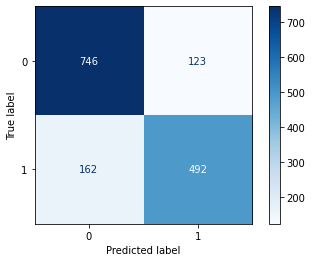

In [24]:
# evaluate the confusion matrix of the trained model
Y_pred = model1.predict(X_test_tf)
cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model1.classes_)
disp.plot(cmap='Blues')
plt.show()

Now, let's calculate precision, recall, and F1-Score for each category using `classification_report` function from sklearn:

In [25]:
print(classification_report(Y_test, Y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       869
           1       0.80      0.75      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523



# 5. Using Cross-Validation to Estimate Realistic Accuracy Metrics:

**Cross-validation** is a technique where all data are used for training and evaluation. In other words, the model is trained on different splits of the dataset and also evaluated on different splits in a repetitive manner.

> Cross-validation is **important** to understand the true potential of any model.

> Using cross-validation allows us to use all observations. That is, we do **NOT** need to create a separate hold-out **test split**.

In [26]:
# Vectorization again because we are going to use the entire dataset not just the train split:


tfidf = TfidfVectorizer(min_df = 1, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df_train['clean_text'])#.toarray() # convert sparse matrix to an array

# Cross Validation with 5 folds

scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df_train['target'],
                         cv=5)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.71897571 0.64281024 0.65856861 0.68791064 0.76018397]
Mean value across of validation scores  0.6936898351427908
Standard deviation of validation scores  0.04222908265927855


# 6. Hyperparameter Tuning with Grid Search
Grid search aims to improve model performance by trying different combination of hyperparameters that can maximize a given metric (e.g., accuracy) for ML model. To test the right choice of hyperparameters for our model: 
1. Create `training_pipeline` where we define steps to run (e.g., TF-IDF vectorization, training `LinearSVC` model) 
2. Define different sets of hyperparameters to test. A single parameter is defined in form `StepName_HyperparameterName`. 
3. Use `GridSearchCV` that tests different sets of hyperparameters for our model and performs cross-validation. Finally, we can pick the best-performing model.
4. Save the best model chosen by the search
5. Use the best model to make predictions and evaluate the results using e.g., the confusion matrix

In [27]:
# 1.
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), 
           ('model', LinearSVC(random_state=21, tol=1e-5))])
# 2. 
grid_param = [{
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

# 3. 
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)

# we use text column because our pipeline contains victorizer 
gridSearchProcessor.fit(df_train['clean_text'], df_train['target'])

# 4. Save the best model chosen by the search, i.e. estimator which gave highest score
best_model = gridSearchProcessor.best_estimator_

# parameter setting that gave the best results on the hold out data.
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

# mean cross-validated score of the best_estimator
best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 6)}
Best result identified by grid search  0.6997318384853188


# 7. Fine-Tuning BERT:

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [28]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [29]:
df_train.sample(5, random_state=42)

,keyword,location,text,target,length,text_c,clean_text
2644,destruction,unknown,So you have a new weapon that can cause un-imaginable destruction.,1,66,So you have a new weapon that can cause un-imaginable destruction.,So you have a new weapon that can cause un-imaginable destruction.
2227,deluge,unknown,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0,119,The f&@ing things I do for GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,The f& things I do for GISHWHES Just got soaked in a deluge going for pads and tampons. Thx
5448,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,1,125,@georgegalloway: @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,UIThe CoL police can catch a pickpocket in Liverpool Stree...
132,aftershock,unknown,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0,114,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.
6845,trauma,"Montgomery County, MD",in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0,105,in response to trauma Children of Addicts develop a defensive self one that decreases vulnerability. (3,in response to trauma Children of Addicts develop a defensive self one that decreases vulnerability.


In [30]:
# combining features into strings

# This will hold all of the dataset samples, as strings.
#sen_w_feats = []

# The labels for the samples.
#labels = []

# For each of the samples...
#for index, row in df_train.iterrows():

    # Piece it together...    
#    combined = ""
    
    
    #combined += "The ID of this item is {:}, ".format(row["Clothing ID"])
#    combined += "The keyword of this tweet is {:}," \
#                 "and is tagged with the {:} location. ".format(row["keyword"], 
#                                                       row["location"])
    
#    combined += "It has {:} characters. ".format(row["length"])
    
    
    
    # Finally, append the review the text!
#    combined += row["clean_text"]
    
    # Add the combined text to the list.
#    sen_w_feats.append(combined)

    # Also record the sample's label.
#    labels.append(row["target"])

#print('  DONE.')

Let's extract the sentences and labels of our training set as numpy ndarrays.

In [31]:
X_train.values

array(['Sassy city girl country hunk stranded in Smoky Mountain snowstorm AoMS ibooklove bookboost',
       "God's Kingdom will rule over all people on the earth after Armageddon.",
       'Mopheme and Bigstar Johnson are a problem in this game body bagging niggas VuzuHustle',
       ...,
       "PBBan Russaky89 'aRmageddon DO NOT KILL FLAGS ONLY Fast XP' for Reason",
       'Petition Heartless owner that whipped horse until it collapsed is told he can KEEP his animal! Act Now!',
       "That's beyond adorable. I hope it won't be wrecked now that it's been noticed ..."],
      dtype=object)

In [32]:
# Get the lists of sentences and their labels.
sentences = df_train["clean_text"].values 
labels = df_train["target"].values  

#sentences = X_train.values 
#labels = Y_train.values

## 1. Tokenization & Input Formatting
In this section, we'll transform our dataset into the format that BERT can be trained on.

### 1.1 BERT Tokenizer
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization **must** be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [33]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Let's apply the tokenizer to one sentence just to see the output.

In [34]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 8372, 2089, 16455, 9641, 2149, 2035]


> When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle **both steps**, rather than calling `tokenize` and `convert_tokens_to_ids` separately. **Before** we can do that, though, we need to talk about some of BERT's formatting requirements.

### 1.2. Required Formatting
The above code left out a few required formatting steps that we'll look at here. We are required to:

1. Add **special tokens** to the start and end of each sentence.
2. **Pad & truncate** all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "**attention mask**".

#### Special Tokens
**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence. This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)

On the output of the final (12th) transformer, only the **first embedding** (corresponding to the [CLS] token) is used by the classifier.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. Because BERT is trained to **only** use this `[CLS]` token for **classification**, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!

#### Sentence Length & Attention Mask

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. **All** sentences **must be padded** or **truncated** to a single, **fixed length**.
2. The maximum sentence length is **512 tokens**.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

The "**Attention Mask**" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT **not to incorporate** these **PAD tokens** into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`

### 1.3. Tokenize Dataset
The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [35]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  77


Just in case there are some longer test sentences, I'll set the maximum length to 90.


Now we're ready to perform the **real tokenization**.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. **Split** the sentence into tokens.
2. Add the **special** `[CLS]` and `[SEP]` tokens.
3. **Map** the tokens to their IDs.
4. **Pad** or **truncate** all sentences to the same length.
5. Create the **attention masks** which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).

In [36]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 90,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
Token IDs: tensor([  101,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  8372,  2089,
        16455,  9641,  2149,  2035,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


### 1.4. Training & Validation Split
Divide up our training set to use 90% for training and 10% for validation.

In [37]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

6471 training samples
1142 validation samples


We'll also create an **iterator** for our dataset using the torch `DataLoader` class. This helps **save on memory** during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [38]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## 2. Train Our Classification Model
Now that our input data is properly formatted, it's time to fine tune the BERT model.

### 2.1. `BertForSequenceClassification`
For this task, we first want to **modify** the pre-trained BERT model to give outputs for classification, and then we want to **continue training the model on our dataset** until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* `BertModel`
* `BertForPreTraining`
* `BertForMaskedLM`
* `BertForNextSentencePrediction`
* **`BertForSequenceClassification`** - The one we'll use.
* `BertForTokenClassification`
* `BertForQuestionAnswering`

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).

We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the **normal BERT** model with an added **single linear layer** on top for classification that we will use as a sentence classifier. As we feed input data, the entire **pre-trained BERT** model and the additional untrained **classification layer** is **trained** on our specific task. 
> There is two strategies here: freezing and fine-tuning the weights of the pre-trained BERT

OK, let's load BERT! There are a few different pre-trained BERT models available. "`bert-large-uncased`" means the version that has only lowercase letters ("uncased") and is the larger version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [39]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-large-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2,      # The number of output labels--2 for binary classification.
                         # You can increase this for multi-class tasks.   
    output_attentions = False,    # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.

In [40]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

### 2.2. Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
>- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
>- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [41]:
optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=2e-5, 
                                  betas=(0.9, 0.999), 
                                  eps=1e-08)

In [42]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is  [number of epochs] x [number of batches] => 4 x 215 or 4 x (6880/32) 
# (Note that this is NOT the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### 2.3. Training Loop 

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a **Trianing phase** and a **Validation phase**. 


**Training phase:**
- *Unpack* our data inputs and labels
- *Load* data onto the GPU for acceleration
- *Clear* out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- *Forward pass* (feed input data through the network)
- *Backward pass* (backpropagation)
- Tell the network to *update parameters* with `optimizer.step()`
- *Track* variables for monitoring progress

**Validation phase:**
- *Unpack* our data inputs and labels
- *Load* data onto the GPU for acceleration
- *Forward pass* (feed input data through the network)
- Compute *loss* on our *validation data* and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

> Define a helper function for calculating accuracy.

In [43]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

> Helper function for formatting elapsed times as `hh:mm:ss`

In [44]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready to kick off the training!

In [45]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    203.    Elapsed: 0:00:37.
  Batch    80  of    203.    Elapsed: 0:01:14.
  Batch   120  of    203.    Elapsed: 0:01:50.
  Batch   160  of    203.    Elapsed: 0:02:27.
  Batch   200  of    203.    Elapsed: 0:03:03.

  Average training loss: 0.46
  Training epcoh took: 0:03:05

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.40
  Validation took: 0:00:10

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    203.    Elapsed: 0:00:36.
  Batch    80  of    203.    Elapsed: 0:01:13.
  Batch   120  of    203.    Elapsed: 0:01:49.
  Batch   160  of    203.    Elapsed: 0:02:26.
  Batch   200  of    203.    Elapsed: 0:03:02.

  Average training loss: 0.32
  Training epcoh took: 0:03:04

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.40
  Validation took: 0:00:10

Training complete!
Total training took 0:06:30 (h:mm:ss)


Let's view the summary of the training process.

In [46]:
# Display floats with two decimal places.
pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.4561,0.3984,0.8400,0:03:05,0:00:10
2,0.3202,0.4038,0.8435,0:03:04,0:00:10


Notice that, while the the **training loss** is going **down** with each epoch, the **validation loss** is **increasing**! This suggests that we are training our model too long, and it's **overfitting** on the training data.

**Validation Loss** is a **more precise** measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.

If we are predicting the correct answer, but with less confidence, then **validation loss** will catch this, while accuracy will **not**.

In [47]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_stats.index,
                         y = df_stats["Training Loss"],
                         mode = 'lines+markers',
                         name = "Training Loss",
                         line = dict(color="#BE0303", width=2)))
    
fig.add_trace(go.Scatter(x = df_stats.index,
                         y = df_stats["Valid. Loss"],
                         mode = 'lines+markers',
                         name = "Validation Loss",
                         line = dict(color="#05000E", width=2)))


fig.update_layout(
    legend=dict(y=0.5, traceorder='reversed', font_size=16),
    title_text='Training & Validation Loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    width=1400,
    height=600)

fig.show()

## 3. Performance On Test Set

### 3.1. Data Preparation
We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [48]:
# Load the dataset into a pandas dataframe.
df_test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [49]:
df_test['text_c'] = df_test['text'].apply(clean)
df_test["clean_text"] = df_test["text_c"].apply(preproc)
df_test.sample(7, random_state=42)

,id,keyword,location,text,text_c,clean_text
2406,8051,refugees,NaN,Refugees as citizens - The Hindu http://t.co/GJSaAf3U6K,Refugees as citizens The Hindu http://t.co/GJSaAf3U6K,Refugees as citizens The Hindu
134,425,apocalypse,Currently Somewhere On Earth,@5SOStag honestly he could say an apocalypse is coming and i would be exited hes so enthusiastic about everything,@5SOStag honestly he could say an apocalypse is coming and i would be exited hes so enthusiastic about everything,honestly he could say an apocalypse is coming and i would be exited hes so enthusiastic about everything
411,1330,blown%20up,Scout Team,If you bored as shit don't nobody fuck wit you... But when you busy yo shit get blown up! Smh,If you bored as shit don't nobody fuck wit you... But when you busy yo shit get blown up! Smh,If you bored as shit don't nobody fuck wit you... But when you busy yo shit get blown up! Smh
203,663,attack,NaN,@RealTwanBrown Yesterday I Had A Heat Attack ???? And What's Funny Our Relationship ??? Or Our Snapchat,@RealTwanBrown Yesterday I Had A Heat Attack ???? And What's Funny Our Relationship ??? Or Our Snapchat,Yesterday I Had A Heat Attack ???? And What's Funny Our Relationship ??? Or Our Snapchat
889,2930,danger,Leeds,The Devil Wears Prada is still one of my favourite films ??,The Devil Wears Prada is still one of my favourite films ??,The Devil Wears Prada is still one of my favourite films ??
1432,4743,evacuate,San Diego,my father fucking died when the north tower collapsed ON HIM as he was trying to evacuate more people from the building.,my father fucking died when the north tower collapsed ON HIM as he was trying to evacuate more people from the building.,my father fucking died when the north tower collapsed ON HIM as he was trying to evacuate more people from the building.
3024,9981,tsunami,Okinawa,Oh itÛªs a soccer ball? I thought it was the head of a melting snowman.,Oh itÛªs a soccer ball? I thought it was the head of a melting snowman.,Oh itUas a soccer ball? I thought it was the head of a melting snowman.


In [50]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(X_test.shape[0]))

# Create sentence and label lists
# Get the lists of sentences and their labels.
sentences = df_test["clean_text"].values 
#labels = df_test["target"].values  
#sentences = X_test.values 
#labels = Y_test.values  

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 90,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)#, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,523



### 3.2. Evaluate on Test Set
With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [51]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
#predictions , true_labels = [], []
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  #b_input_ids, b_input_mask, b_labels = batch
  b_input_ids, b_input_mask = batch

  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  #true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [52]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
#flat_true_labels = np.concatenate(true_labels, axis=0)

In [53]:
my_submission = pd.DataFrame({"id": df_test["id"], "target": flat_predictions})

my_submission.to_csv('submission.csv', index=False)

In [54]:
my_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [55]:
# evaluate the confusion matrix of the trained model

#cm = confusion_matrix(flat_true_labels, flat_predictions)

#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                              display_labels=model1.classes_)
#disp.plot(cmap='Blues')
#plt.show()

In [56]:
#print(classification_report(flat_true_labels, flat_predictions, zero_division = 0))

> - The notebook is inspired by this **amazing book**: [Blueprints for Text Analytics Using Python: Machine Learning-Based Solutions for Common Real World (NLP) Applications](https://www.amazon.de/Blueprints-Text-Analytics-using-Python/dp/149207408X) by *Jens Albrecht, Sidharth Ramachandran, and Christian Winkler*. 
> - BERT section is inspired by the best tutorial for BERT: [BERT Fine-Tuning Tutorial with PyTorch](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) by *Chris McCormick*. 